# Create new utility function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [102]:
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create assays
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')
assays = [log_S_oracle, log_P_oracle]

# create utility function
log_S_evaluator = ClassicEvaluator(
    ideal=(-1.5, 0), # (-2, 0)
    acceptable=(-4, 0.5)
)

log_P_evaluator = ClassicEvaluator(
    ideal=(1, 3), # (1, 4)
    acceptable=(0, 5)
)

utility_function = UtilityFunction(
    evaluators = [log_S_evaluator, log_P_evaluator],
    strategy = lambda x: np.prod(x)
)

First, set up the environment.

In [103]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import matplotlib.cm as cm

def make_box(ranges, color, label):
    
    abs_diff = lambda a, b: abs(a - b)
    width = abs_diff(*ranges[0])
    height = abs_diff(*ranges[1])

    x = np.mean(ranges[0]) - width/2
    y = np.mean(ranges[1]) - height/2
    
    edge_color = to_rgba(color, alpha=1)
    face_color = to_rgba(color, alpha=0.1)

    return patches.Rectangle(
        xy=(x, y),
        width=width,
        height=height,
        facecolor=face_color,
        edgecolor=edge_color,
        linestyle='--',
        label=label
    )

In [104]:
def plot(assay_results, utility, utility_function):

    # create basic plot
    g = sns.jointplot(
        x=assay_results[0],
        y=assay_results[1],
    )

    # add evaluator boundaries
    evals = utility_function.evaluators
    ideal = g.ax_joint.add_patch(
        make_box(
            ranges=[evals[0].ideal, evals[1].ideal],
            color='green', label='Ideal'
        )
    )
    acceptable = g.ax_joint.add_patch(
        make_box(
            ranges=[evals[0].acceptable, evals[1].acceptable],
            color='#c0c0c0', label='Acceptable'
        )
    )

    # move to back
    plt.setp(g.ax_joint.patches, zorder=-1)

    # create legend
    g.ax_joint.legend(
        bbox_to_anchor=(1.2, 1),
        loc='upper left'
    )

    # labels
    plt.xlabel(assays[0].name)
    plt.ylabel(assays[1].name)

    # formatting
    g.fig.set_figwidth(6)
    g.fig.set_figheight(3)
    g.fig.set_dpi(300)

In [116]:
import numpy as np
import seaborn as sns

# housekeeping
assay_results = [assay(deck) for assay in assays]
utility = np.array([
    utility_function(properties)
    for properties in zip(*assay_results)
])
chosen_molecules = utility.argsort()[[203]].tolist()
# plot(assay_results, utility, utility_function)

In [117]:
from dgym.envs.drug_env import DrugEnv

# instantiate drug_env
drug_env = DrugEnv(
    library_designer,
    library = deck[chosen_molecules],
    assays = assays,
    budget = 100_000
)

# housekeeping
assay_results = [assay(drug_env.library) for assay in assays]
utility = np.array([
    utility_function(properties)
    for properties in zip(*assay_results)
])

best_observed = max(utility)
dist_over_time = [{'utility': u, 'round': 0} for u in utility]

print(drug_env.library)

MoleculeCollection with 1 Molecules


In [118]:
import random

max_rounds = 20
round_ = 1
while best_observed < 1.0:

    print(round_, '\t', drug_env.library, '\t', best_observed)
    
    # ideate
    action = {
        'design': {
            'molecules': chosen_molecules,
            'num_analogs': 1, # maps to 10 molecules
            'fraction_random': 0.5
        }
    }
    library = drug_env.step(action)[0]

    # score
    assay_results = [assay(library) for assay in assays]
    utility = np.array([
        utility_function.score(properties)
        for properties in zip(*assay_results)
    ])

    # triage
    chosen_molecules = utility.argsort()[-5:].tolist()
    if len(library) > 100:
        chosen_molecules.extend(random.sample(range(len(library)), 2))

    # housekeeping
    best_observed = max([*utility, best_observed])
    dist_over_time.extend([
        {'utility': u, 'round': round_} for u in utility[chosen_molecules]
    ])

    # assay
    drug_env.step({'order': {'assay': 0, 'molecules': chosen_molecules}})
    drug_env.step({'order': {'assay': 1, 'molecules': chosen_molecules}})
    
    round_ += 1
    if round_ == 15:
        break

    # update model (TODO)
    
print(round_, '\t', drug_env.library, '\t', best_observed)

1 	 MoleculeCollection with 1 Molecules 	 0.5899851322174072
2 	 MoleculeCollection with 1 Molecules 	 0.5899851322174072
3 	 MoleculeCollection with 77 Molecules 	 0.7766404628753663
4 	 MoleculeCollection with 440 Molecules 	 0.9980683565139771
5 	 MoleculeCollection with 967 Molecules 	 1.0


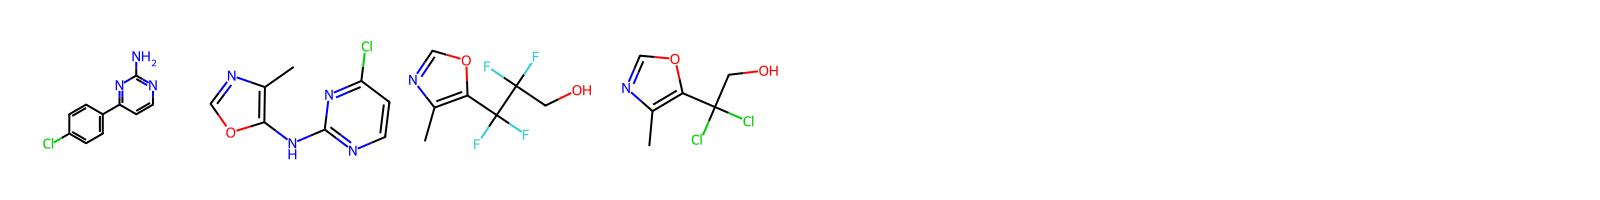

0.5899851322174072		0.7441461086273193		0.9980683565139771		1


(-3.550074338912964, 2.3792)

(-2.7792694568634033, 2.170019999999999)

(-1.5096582174301147, 1.70242)

(-1.1219308376312256, 1.6057200000000003)

In [119]:
from rdkit.Chem import Draw

index = int(utility.argsort()[-1])

mol = drug_env.library[index]
lineage = [mol]
while mol.inspiration:
    mol = mol.inspiration
    lineage.insert(0, mol)

# Counter([o.mol for o in original_inspirations]).most_common(20)

assay_results = [assay(lineage) for assay in assays]
results = [
    utility_function.score(properties)
    for properties in zip(*assay_results)
]

display(Draw.MolsToGridImage(
    [m.mol for m in lineage],
    molsPerRow=8,
    maxMols=10_000
))

print('\t\t'.join(map(str, results)))
display(*zip(*assay_results))

<Axes: xlabel='round', ylabel='utility'>

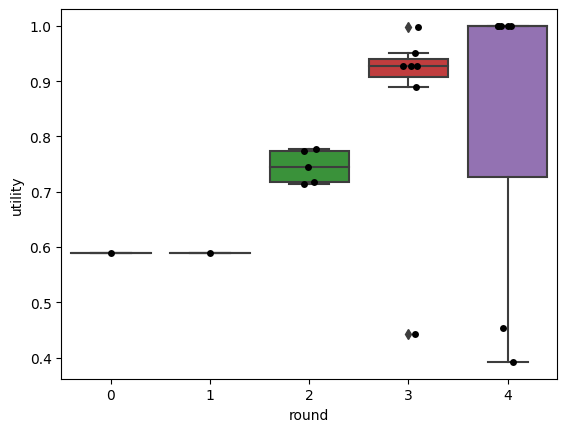

In [120]:
import pandas as pd
import seaborn as sns

sns.boxplot(
    pd.DataFrame(dist_over_time),
    x='round',
    y='utility'
)

sns.stripplot(
    pd.DataFrame(dist_over_time),
    x='round',
    y='utility',
    color='#000'
)

In [32]:
from dgym.agents import DrugAgent

In [33]:
drug_agent = DrugAgent(drug_env.action_space)